In [6]:
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams
import warnings
from pandas.core.nanops import nanmean as pd_nanmean
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit 
from statsmodels.tsa.stattools import adfuller


warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
data = pd.read_csv('data.csv', sep =',')
data.head()
# 1,2,3,4 - sector_id - юр лица
# 1 - bank_id
# value_rub

,report_date,sector_id,bank_group_id,value_rub,value_usd
0,2007-02-01,40,6,9.408740,8.925271
1,2007-02-01,10,6,31.943854,36.274318
2,2007-02-01,41,6,48.045392,20.535636
3,2007-02-01,12,6,4.604419,15.616651
4,2007-02-01,15,6,0.041111,0.000002


In [8]:
#тест - год . тренд сезонность выделить. rmse. эвристика - рост

In [9]:
data.sort_values('report_date',axis = 0,inplace =True)
data['report_date'] = pd.to_datetime(data.report_date,format='%Y-%m-%d %H:%M:%S') 
data.index  = data.report_date
data.drop('report_date', axis = 1, inplace = True)
data.drop('value_usd', axis = 1, inplace = True)
data = data[(1<=data.sector_id) & (data.sector_id <=4) & (data.bank_group_id == 1)]
data.drop('bank_group_id', axis = 1, inplace = True)
data = data.astype({"sector_id": str})
data.head()

,sector_id,value_rub
report_date,,
2007-02-01,2,27.283416
2007-02-01,1,0.920018
2007-02-01,3,7.342596
2007-02-01,4,47.034125
2007-03-01,2,44.244502


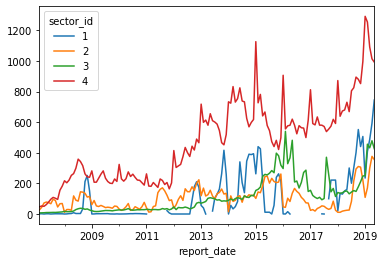

In [10]:
data_pivot = pd.pivot_table(data, values = "value_rub", columns = "sector_id", index="report_date")
data_pivot.plot()
data = data_pivot

In [11]:
data.head()

sector_id,1,2,3,4
report_date,,,,
2007-02-01,0.920018,27.283416,7.342596,47.034125
2007-03-01,1.580018,44.244502,7.490046,52.539326
2007-04-01,0.000018,72.162548,8.279246,50.248941
2007-05-01,1.500018,78.071495,9.536747,61.427180
2007-06-01,1.600018,74.903469,9.561188,77.904334


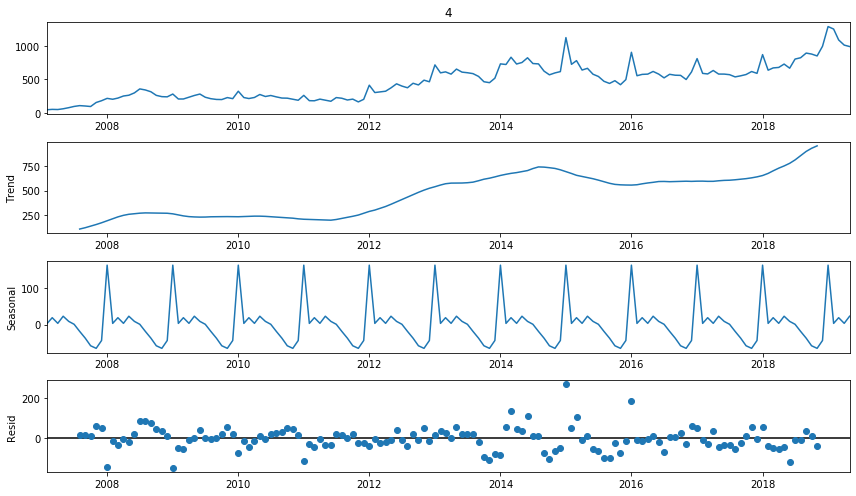

In [12]:
rcParams['figure.figsize'] = 12, 7
result = sm.tsa.seasonal_decompose(data['4'].dropna(), model='additive', freq=12)
result.plot()
plt.show()

In [13]:
mouths = 12
train1 = data['1'].dropna().iloc[:-mouths]
test1 = data['1'].dropna().iloc[-mouths:]
train2 = data['2'].dropna().iloc[:-mouths]
test2 = data['2'].dropna().iloc[-mouths:]
train3 = data['3'].dropna().iloc[:-mouths]
test3 = data['3'].dropna().iloc[-mouths:]
train4 = data['4'].dropna().iloc[:-mouths]
test4 = data['4'].dropna().iloc[-mouths:]


In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit 
def rmse(y_actual, y_predicted):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    return rmse
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mean(lst): 
    return sum(lst) / len(lst) 

In [15]:
#baseline
from statsmodels.tsa.api import ExponentialSmoothing, Holt

In [16]:
#двойное сглаживание
print('Holt')
print('rmse, ','mape, ','level, ','slope')
for test, train in [(test1,train1),(test2,train2),(test3,train3),(test4,train4)]:
    metric = []
    #найдем на валидации оптимальные параметры
    for level in  np.arange(0.1, 1, 0.1):
        for slope in  np.arange(0.1, 1, 0.1):
            rmse_l = []
            mape_l = []
            tscv = TimeSeriesSplit(n_splits=4) 
            for train_idx, test_idx in tscv.split(train):
                actual = train[test_idx]
                fit = Holt(np.asarray(train[train_idx].dropna())).fit(smoothing_level = level,smoothing_slope = slope)
                forecast = fit.forecast(len(test_idx))
                rmse_l.append(rmse(actual, forecast))
                mape_l.append(mape(actual, forecast))
                              
            metric.append((mean(rmse_l),mean(mape_l), level,slope))
            #print('MAPE - ',mape[-1])
    best = min(metric)
    fit = Holt(np.asarray(train.dropna())).fit(smoothing_level = best[2],smoothing_slope = best[3])
    preds = fit.forecast(len(test))
    print(rmse(test.values,  preds),mape(test.values,  preds), best[2], best[3])

Holt
rmse,  mape,  level,  slope
297.39768864713193 55.1704615483985 0.5 0.1
262.55901010484575 98.1448133119263 0.30000000000000004 0.1
245.83132679732654 56.86387024150464 0.1 0.1
253.01066126361206 19.75518688324501 0.4 0.1


In [17]:
#тройное сглаживание
print('ExponentialSmoothing')
print('rmse, ','mape, ','trend, ','seasonal')
for test, train in [(test1,train1),(test2,train2),(test3,train3),(test4,train4)]:
    metric = []
    #найдем на валидации оптимальные параметры
    for trend in ["add", "mul", "additive", "multiplicative"]:
        for season in ["add", "mul", "additive", "multiplicative"]:
            rmse_l = []
            mape_l = []
            tscv = TimeSeriesSplit(n_splits=4) 
            for train_idx, test_idx in tscv.split(train):
                actual = train[test_idx]
                fit = ExponentialSmoothing(np.asarray(train[train_idx].dropna()+ 1),seasonal_periods=12 ,trend=trend, seasonal=season).fit()
                forecast = fit.forecast(len(test_idx))
                if not np.isnan(forecast).mean() > 0 :
                    rmse_l.append(rmse(actual, forecast))
                    mape_l.append(mape(actual, forecast))
                              
            metric.append((mean(rmse_l),mean(mape_l), trend,season))
            
    best = min(metric)
    fit = ExponentialSmoothing(np.asarray(train.dropna() + 1),seasonal_periods=12 ,trend=best[2], seasonal=best[3]).fit()
    preds = fit.forecast(len(test))
    print((rmse(test.values + 1,  preds),mape(test.values+1,  preds), best[2],best[3]))

ExponentialSmoothing
rmse,  mape,  trend,  seasonal
(298.33041233176675, 54.65293473389995, 'add', 'add')
(233.68067367650417, 81.609966678834, 'add', 'mul')
(177.00628411676848, 33.59964431651959, 'add', 'add')
(262.73653114431403, 23.628009923705772, 'add', 'add')


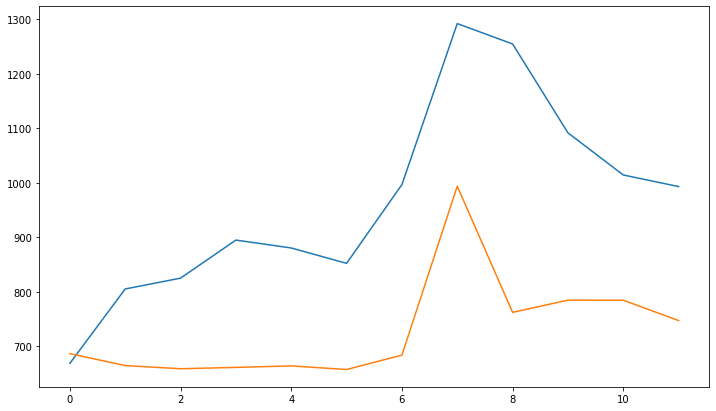

In [18]:
plt.plot(test4.values)
plt.plot(preds)

In [19]:
#Лаговая модель

In [20]:
from sklearn.linear_model import LinearRegression

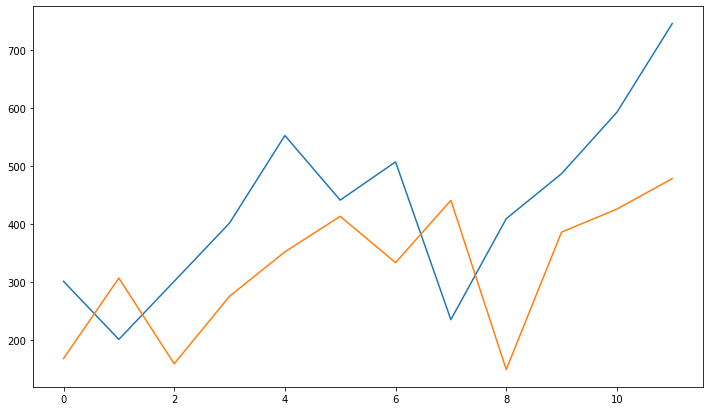

40.658533790709036 171.96665915416446


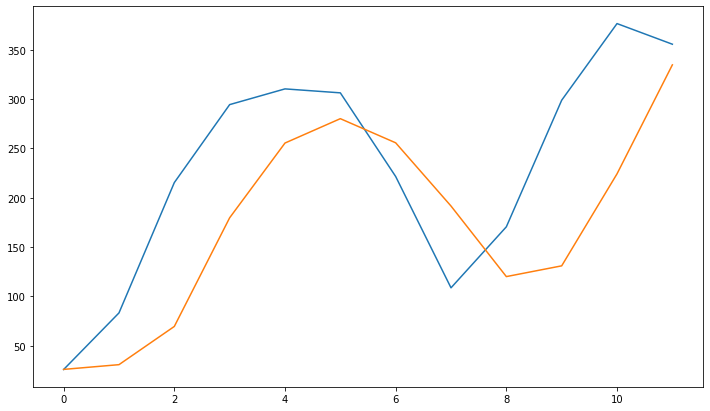

35.0066539028788 92.79069221965652


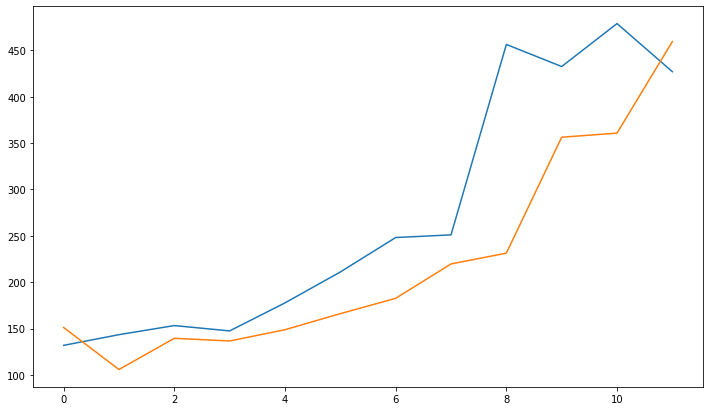

19.40054397473037 82.49822777761689


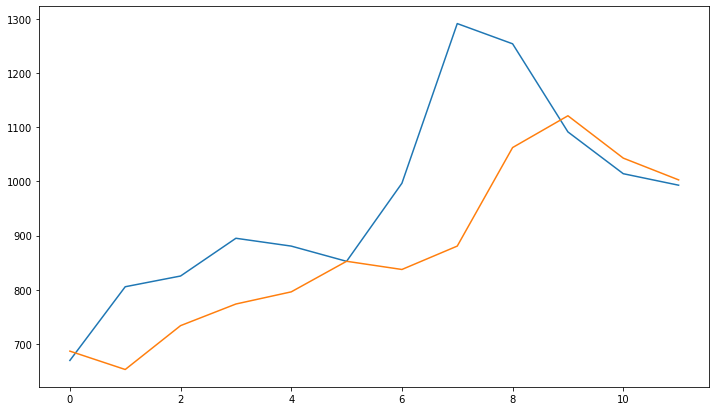

10.466234490824165 154.74405007274174


In [28]:
for test, train in [(test1,train1),(test2,train2),(test3,train3),(test4,train4)]:
    test_len = len(test)
    df = pd.concat((train,test), axis = 0).to_frame()
    df.columns = ['target']
    lag_period = 1
    features = []
    for period_mult in range(1,12,1):
        df["lag_period_{}".format(period_mult)] = df.target.shift(period_mult*lag_period)
        features.append("lag_period_{}".format(period_mult))
    test = df.iloc[-test_len:].dropna()
    train = df.iloc[:-test_len].dropna()

    model = LinearRegression()
    model.fit(train.drop('target', axis = 1),train['target'])
    forecast = model.predict(test.drop('target', axis = 1))
    plt.figure()
    plt.plot(test.target.values)
    plt.plot(forecast)
    plt.show()
    print(mape(test.target.values, forecast),rmse(test.target.values, forecast))

In [25]:
#лаговая модель с линейной регрессией дала лучший результат
#наблюдается что линейная модель как бы чуть чуть "запаздывает" с предсказанием 